# Explicit Feature Maps for the Intersection Kernel

In this example, we run `MB`, which is the explicit feature map for the intersection kernel, and `SparseMBClassifier`, which is a linear model with the sparse explicit feature map for the intersection kernel.

The intersection kernel $$K(\mathbf{x}, \mathbf{y}) = \sum_{i=1}^n \min (x_i, y_i)$$

is used in computer vision task.

## Dataset
We use the **INRIAPerson dataset** that is aviabale at http://pascal.inrialpes.fr/data/human/.
In this example, we assume that the dataset is located here (./).
`pos_img_dir_tr`, `neg_img_dir_tr`, `pos_img_dir_te`, `neg_img_dir_te` are file pathes for data.

## Create HOG features

In [1]:
# Author referred the implementation at https://github.com/Ermlab/hog-svm-inria
import os
from skimage import io
from skimage.feature import hog
import numpy as np

W = 64
H = 128

def load_hog_data(pos_img_dir, neg_img_dir, random_state,
                  n_pos_samples=5, n_neg_samples=10):
    pos_img_files = os.listdir(pos_img_dir)
    neg_img_files = os.listdir(neg_img_dir)
    X = []
    y = []
    print('start loading ' + str(len(pos_img_files)) + ' positive files')
    for pos_img_file in pos_img_files:
        pos_filepath = pos_img_dir + pos_img_file
        pos_img = io.imread(pos_filepath, as_gray=True)
        for i in range(n_pos_samples):
            leftop_y = random_state.randint(pos_img.shape[0] - H)
            leftop_x = random_state.randint(pos_img.shape[1] - W)
            pos_roi = pos_img[leftop_y:leftop_y+H, leftop_x:leftop_x+W]
            fd = hog(pos_roi, orientations=9, pixels_per_cell=(8, 8),
                     cells_per_block=(2, 2), visualize=False)
            X.append(fd)
            y.append(1)
    
    print('start loading ' + str(len(neg_img_files)) + ' negative files')
    for neg_img_file in neg_img_files:
        neg_filepath = neg_img_dir + neg_img_file
        neg_img = io.imread(neg_filepath, as_gray=True)
        for i in range(n_neg_samples):
            leftop_y = random_state.randint(neg_img.shape[0] - H)
            leftop_x = random_state.randint(neg_img.shape[1] - W)
            neg_roi = neg_img[leftop_y:leftop_y+H, leftop_x:leftop_x+W]
            fd = hog(neg_roi, orientations=9, pixels_per_cell=(8, 8), 
                     cells_per_block=(2, 2), visualize=False)
            X.append(fd)
            y.append(-1)
    ## covert list into numpy array
    X = np.array(X)
    y = np.array(y)
    return X, y

In [2]:
# put your path to INRIAPerson dataset that is aviabale 
# at http://pascal.inrialpes.fr/data/human/
pos_img_dir_tr = 'INRIAPerson/train_64x128_H96/pos/'
neg_img_dir_tr = 'INRIAPerson/train_64x128_H96/neg/'
pos_img_dir_te = 'INRIAPerson/test_64x128_H96/pos/'
neg_img_dir_te = 'INRIAPerson/test_64x128_H96/neg/'
from sklearn.utils import shuffle
random_state = np.random.RandomState(0)
X_train, y_train = load_hog_data(pos_img_dir_tr, neg_img_dir_tr,
                                 random_state, 3, 6)
X_test, y_test = load_hog_data(pos_img_dir_te, neg_img_dir_te,
                               random_state, 2, 5)
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

start loading 2416 positive files
start loading 1218 negative files
start loading 1126 positive files
start loading 453 negative files
(14556, 3780) (14556,)
(4517, 3780) (4517,)


In [3]:
# number of non-zero elements
print(np.count_nonzero(X_train) / np.prod(X_train.shape))

0.9416213209047779


In [4]:
from sklearn.svm import SVC, LinearSVC
from pyrfm.kernels import intersection
from pyrfm import MB, SparseMBClassifier, SparseMB
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

/mnt/c/Users/kyohei/home_ubuntu/.local/share/virtualenvs/pipenv3.7.4-rkmnVTJV/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## `LinearSVC` with HOG feature

In [5]:
%%time
clf = LinearSVC(dual=False, random_state=0)
clf.fit(X_train, y_train)
y_score = clf.decision_function(X_test)
acc = accuracy_score(y_true=y_test, y_pred=np.sign(y_score))
roc_auc = roc_auc_score(y_true=y_test, y_score=y_score)
print("Accuracy :{}".format(acc))
print("ROC AUC: {}".format(roc_auc))
fpr_linear, tpr_linear, _ = roc_curve(y_test, y_score)

Accuracy :0.9032543723710428
ROC AUC: 0.9676486733401557
CPU times: user 26.1 s, sys: 328 ms, total: 26.4 s
Wall time: 26.7 s


## `SVC` with intersection kernel
 - Using all samples is prohibitive
 - We use only 2,000 samples and set `max_iter=500`

In [7]:
%%time
clf = SVC(kernel=intersection, cache_size=3000, max_iter=500)
clf.fit(X_train[:2000], y_train[:2000])
clf.score(X_test, y_test)
y_score = clf.decision_function(X_test)
acc = accuracy_score(y_true=y_test, y_pred=np.sign(y_score))
roc_auc = roc_auc_score(y_true=y_test, y_score=y_score)
print("Accuracy :{}".format(acc))
print("ROC AUC: {}".format(roc_auc))
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_score)

/mnt/c/Users/kyohei/home_ubuntu/.local/share/virtualenvs/pipenv3.7.4-rkmnVTJV/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Accuracy :0.9143236661500996
ROC AUC: 0.9753935672583408
CPU times: user 3min 50s, sys: 375 ms, total: 3min 50s
Wall time: 3min 54s


## `LinearSVC` with `MB`
 - You can use `MB` in the same way as other transformers

In [8]:
%%time
transformer = MB(n_components=20*X_train.shape[1])
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)
clf = LinearSVC()
clf.fit(X_train_trans, y_train)
y_score = clf.decision_function(X_test_trans)
acc = accuracy_score(y_true=y_test, y_pred=np.sign(y_score))
roc_auc = roc_auc_score(y_true=y_test, y_score=y_score)
print("Accuracy :{}".format(acc))
print("ROC AUC: {}".format(roc_auc))
fpr_mb, tpr_mb, _ = roc_curve(y_test, y_score)

/mnt/c/Users/kyohei/home_ubuntu/.local/share/virtualenvs/pipenv3.7.4-rkmnVTJV/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy :0.9360194819570511
ROC AUC: 0.9816192817569078
CPU times: user 2min 40s, sys: 14.1 s, total: 2min 54s
Wall time: 2min 58s


In [9]:
# Sparsity of the MB features
print(X_train_trans.nnz / np.prod(X_train_trans.shape))

0.15266360732714815


## `SparseMBClassifier`
- This is a linear model with the sparse explicit feature map for the intersection kernel
- You can use it in the same way as other classifiers

In [10]:
%%time
clf = SparseMBClassifier(n_components=X_train.shape[1]*20, max_iter=100,
                         verbose=False, random_state=0)
clf.fit(X_train, y_train)
y_score = clf.decision_function(X_test)
acc = accuracy_score(y_true=y_test, y_pred=np.sign(y_score))
roc_auc = roc_auc_score(y_true=y_test, y_score=y_score)
print("Accuracy :{}".format(acc))
print("ROC AUC: {}".format(roc_auc))
fpr_sparsemb, tpr_sparsemb, _ = roc_curve(y_test, y_score)

Accuracy :0.9211866282931149
ROC AUC: 0.9753039731178368
CPU times: user 1min 45s, sys: 10.2 s, total: 1min 55s
Wall time: 1min 59s


## ROC Curves
- The curve reaching to the top left is better

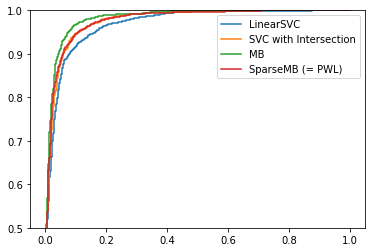

In [13]:
%matplotlib inline
plt.plot(fpr_linear, tpr_linear, label='LinearSVC')
plt.plot(fpr_svc, tpr_svc, label='SVC with Intersection')
plt.plot(fpr_mb, tpr_mb, label='MB')
plt.plot(fpr_sparsemb, tpr_sparsemb,
         label='SparseMB (= PWL)')
plt.ylim([0.5, 1])
plt.legend()
plt.show()